In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from model import RBM
from data_loader import MNISTDataLoader
import pandas as pd
from tqdm import tqdm
import gc
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams["axes.unicode_minus"] = False

torch.manual_seed(42)
np.random.seed(42)

In [2]:
class RBMTrainer:
    def __init__(self, rbm, device):
        self.device = device
        self.rbm = rbm
        self.rbm.to(self.device)
        self.train_errors = []
        self.val_errors = []
        
    def preprocess_data(self, data):
        data = data.view(data.size(0), -1).to(self.device)
        data = torch.clamp(data, 0, 1)
        data = torch.bernoulli(data)
        return data
    
    def train(self, train_loader, val_loader, max_epochs):
        self.rbm.train()
        
        for epoch in range(max_epochs):
            epoch_errors = []

            for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{max_epochs}')):
                data = self.preprocess_data(data)
                # 对比散度
                v0, h0, v_k, ph_k = self.rbm.contrastive_divergence(data)
                # 更新参数
                self.rbm.update_parameters(v0, h0, v_k, ph_k, data.size(0))
                # 计算重构误差
                with torch.no_grad():
                    error = self.rbm.reconstruction_error(data)
                epoch_errors.append(error.item())
                # 清理内存
                if batch_idx % 50 == 0:
                    gc.collect()
            
            # 计算平均训练误差
            avg_train_error = np.mean(epoch_errors)
            self.train_errors.append(avg_train_error)
            print(f'Epoch {epoch+1}: Train Error = {avg_train_error:.6f}', end='')
            
            # 验证阶段
            val_error = self.validate(val_loader)
            self.val_errors.append(val_error)
            print(f', Val Error = {val_error:.6f}')
            
            gc.collect()
        
        return self.train_errors, self.val_errors
    
    def validate(self, val_loader):
        """验证"""
        self.rbm.eval()
        errors = []
        with torch.no_grad():
            for data, _ in val_loader:
                data = self.preprocess_data(data)
                error = self.rbm.reconstruction_error(data)
                errors.append(error.item())
        self.rbm.train()
        return np.mean(errors)

In [12]:
n_visible = 784
n_hidden = 200
batch_size = 64
val_ratio = 0.1
data_dir = './data'
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0001
k = 5
target_error = 0.025
max_epochs = 50
device = torch.device("cuda")

data_loader = MNISTDataLoader(batch_size=batch_size, val_ratio=val_ratio, data_dir=data_dir)
train_loader, val_loader, test_loader = data_loader.get_loaders()

rbm = RBM(
    n_visible=n_visible,
    n_hidden=n_hidden,
    k=k,
    learning_rate=learning_rate,
    momentum=momentum,
    weight_decay=weight_decay
)

trainer = RBMTrainer(rbm, device=device)
print(f"参数: 可见层={n_visible}, 隐藏层={n_hidden}, CD-{k}, 学习率={learning_rate}")
print(f"目标误差: {target_error}")
print(f"批大小: {batch_size}")

参数: 可见层=784, 隐藏层=200, CD-5, 学习率=0.01
目标误差: 0.025
批大小: 64


In [5]:
train_errors, val_errors = trainer.train(
    train_loader, 
    val_loader, 
    max_epochs=max_epochs
)

final_test_error = trainer.validate(test_loader)
print(f"\n最终测试误差: {final_test_error:.6f}")

results = pd.DataFrame({
    'epoch': range(1, len(train_errors) + 1),
    'train_error': train_errors,
    'val_error': val_errors if val_errors else [None] * len(train_errors)
})
results.to_csv('training_results.csv', index=False)

# 显示最终结果摘要
print("\n训练结果摘要:")
print(f"最终训练误差: {train_errors[-1]:.6f}")
print(f"最终测试误差: {final_test_error:.6f}")
print(f"目标误差: {target_error}")

Epoch 1/50: 100%|██████████| 844/844 [00:08<00:00, 104.48it/s]


Epoch 1: Train Error = 0.043042, Val Error = 0.035316


Epoch 2/50: 100%|██████████| 844/844 [00:08<00:00, 100.59it/s]


Epoch 2: Train Error = 0.033183, Val Error = 0.031854


Epoch 3/50: 100%|██████████| 844/844 [00:08<00:00, 103.69it/s]


Epoch 3: Train Error = 0.030712, Val Error = 0.030012


Epoch 4/50: 100%|██████████| 844/844 [00:08<00:00, 101.08it/s]


Epoch 4: Train Error = 0.029263, Val Error = 0.028884


Epoch 5/50: 100%|██████████| 844/844 [00:08<00:00, 104.14it/s]


Epoch 5: Train Error = 0.028306, Val Error = 0.027996


Epoch 6/50: 100%|██████████| 844/844 [00:08<00:00, 97.76it/s] 


Epoch 6: Train Error = 0.027653, Val Error = 0.027462


Epoch 7/50: 100%|██████████| 844/844 [00:08<00:00, 101.37it/s]


Epoch 7: Train Error = 0.027155, Val Error = 0.027173


Epoch 8/50: 100%|██████████| 844/844 [00:08<00:00, 101.23it/s]


Epoch 8: Train Error = 0.026759, Val Error = 0.026855


Epoch 9/50: 100%|██████████| 844/844 [00:08<00:00, 100.83it/s]


Epoch 9: Train Error = 0.026435, Val Error = 0.026490


Epoch 10/50: 100%|██████████| 844/844 [00:08<00:00, 100.85it/s]


Epoch 10: Train Error = 0.026199, Val Error = 0.026350


Epoch 11/50: 100%|██████████| 844/844 [00:08<00:00, 102.93it/s]


Epoch 11: Train Error = 0.025975, Val Error = 0.026145


Epoch 12/50: 100%|██████████| 844/844 [00:08<00:00, 101.86it/s]


Epoch 12: Train Error = 0.025792, Val Error = 0.025888


Epoch 13/50: 100%|██████████| 844/844 [00:08<00:00, 100.06it/s]


Epoch 13: Train Error = 0.025627, Val Error = 0.025765


Epoch 14/50: 100%|██████████| 844/844 [00:08<00:00, 102.83it/s]


Epoch 14: Train Error = 0.025468, Val Error = 0.025737


Epoch 15/50: 100%|██████████| 844/844 [00:08<00:00, 102.00it/s]


Epoch 15: Train Error = 0.025360, Val Error = 0.025467


Epoch 16/50: 100%|██████████| 844/844 [00:08<00:00, 103.74it/s]


Epoch 16: Train Error = 0.025235, Val Error = 0.025392


Epoch 17/50: 100%|██████████| 844/844 [00:08<00:00, 99.24it/s] 


Epoch 17: Train Error = 0.025147, Val Error = 0.025303


Epoch 18/50: 100%|██████████| 844/844 [00:08<00:00, 102.04it/s]


Epoch 18: Train Error = 0.025062, Val Error = 0.025236


Epoch 19/50: 100%|██████████| 844/844 [00:08<00:00, 103.16it/s]


Epoch 19: Train Error = 0.024995, Val Error = 0.025208


Epoch 20/50: 100%|██████████| 844/844 [00:08<00:00, 102.60it/s]


Epoch 20: Train Error = 0.024911, Val Error = 0.025153


Epoch 21/50: 100%|██████████| 844/844 [00:08<00:00, 101.00it/s]


Epoch 21: Train Error = 0.024848, Val Error = 0.025012


Epoch 22/50: 100%|██████████| 844/844 [00:08<00:00, 103.61it/s]


Epoch 22: Train Error = 0.024774, Val Error = 0.024942


Epoch 23/50: 100%|██████████| 844/844 [00:08<00:00, 102.82it/s]


Epoch 23: Train Error = 0.024736, Val Error = 0.024900


Epoch 24/50: 100%|██████████| 844/844 [00:08<00:00, 105.00it/s]


Epoch 24: Train Error = 0.024685, Val Error = 0.024964


Epoch 25/50: 100%|██████████| 844/844 [00:07<00:00, 105.89it/s]


Epoch 25: Train Error = 0.024613, Val Error = 0.024832


Epoch 26/50: 100%|██████████| 844/844 [00:07<00:00, 105.87it/s]


Epoch 26: Train Error = 0.024589, Val Error = 0.024767


Epoch 27/50: 100%|██████████| 844/844 [00:08<00:00, 105.03it/s]


Epoch 27: Train Error = 0.024548, Val Error = 0.024711


Epoch 28/50: 100%|██████████| 844/844 [00:08<00:00, 105.44it/s]


Epoch 28: Train Error = 0.024520, Val Error = 0.024777


Epoch 29/50: 100%|██████████| 844/844 [00:08<00:00, 101.61it/s]


Epoch 29: Train Error = 0.024470, Val Error = 0.024733


Epoch 30/50: 100%|██████████| 844/844 [00:08<00:00, 105.38it/s]


Epoch 30: Train Error = 0.024432, Val Error = 0.024569


Epoch 31/50: 100%|██████████| 844/844 [00:07<00:00, 105.65it/s]


Epoch 31: Train Error = 0.024405, Val Error = 0.024564


Epoch 32/50: 100%|██████████| 844/844 [00:08<00:00, 104.24it/s]


Epoch 32: Train Error = 0.024385, Val Error = 0.024558


Epoch 33/50: 100%|██████████| 844/844 [00:08<00:00, 104.75it/s]


Epoch 33: Train Error = 0.024321, Val Error = 0.024593


Epoch 34/50: 100%|██████████| 844/844 [00:08<00:00, 104.67it/s]


Epoch 34: Train Error = 0.024338, Val Error = 0.024572


Epoch 35/50: 100%|██████████| 844/844 [00:08<00:00, 105.27it/s]


Epoch 35: Train Error = 0.024300, Val Error = 0.024583


Epoch 36/50: 100%|██████████| 844/844 [00:08<00:00, 102.23it/s]


Epoch 36: Train Error = 0.024278, Val Error = 0.024444


Epoch 37/50: 100%|██████████| 844/844 [00:08<00:00, 102.81it/s]


Epoch 37: Train Error = 0.024281, Val Error = 0.024433


Epoch 38/50: 100%|██████████| 844/844 [00:08<00:00, 103.46it/s]


Epoch 38: Train Error = 0.024244, Val Error = 0.024456


Epoch 39/50: 100%|██████████| 844/844 [00:08<00:00, 103.50it/s]


Epoch 39: Train Error = 0.024213, Val Error = 0.024431


Epoch 40/50: 100%|██████████| 844/844 [00:08<00:00, 104.97it/s]


Epoch 40: Train Error = 0.024189, Val Error = 0.024402


Epoch 41/50: 100%|██████████| 844/844 [00:08<00:00, 104.68it/s]


Epoch 41: Train Error = 0.024177, Val Error = 0.024407


Epoch 42/50: 100%|██████████| 844/844 [00:07<00:00, 105.98it/s]


Epoch 42: Train Error = 0.024145, Val Error = 0.024414


Epoch 43/50: 100%|██████████| 844/844 [00:08<00:00, 102.78it/s]


Epoch 43: Train Error = 0.024185, Val Error = 0.024360


Epoch 44/50: 100%|██████████| 844/844 [00:08<00:00, 100.64it/s]


Epoch 44: Train Error = 0.024116, Val Error = 0.024439


Epoch 45/50: 100%|██████████| 844/844 [00:08<00:00, 104.53it/s]


Epoch 45: Train Error = 0.024100, Val Error = 0.024345


Epoch 46/50: 100%|██████████| 844/844 [00:08<00:00, 103.81it/s]


Epoch 46: Train Error = 0.024127, Val Error = 0.024367


Epoch 47/50: 100%|██████████| 844/844 [00:08<00:00, 104.52it/s]


Epoch 47: Train Error = 0.024087, Val Error = 0.024242


Epoch 48/50: 100%|██████████| 844/844 [00:08<00:00, 99.71it/s] 


Epoch 48: Train Error = 0.024072, Val Error = 0.024258


Epoch 49/50: 100%|██████████| 844/844 [00:08<00:00, 104.45it/s]


Epoch 49: Train Error = 0.024071, Val Error = 0.024280


Epoch 50/50: 100%|██████████| 844/844 [00:08<00:00, 103.92it/s]


Epoch 50: Train Error = 0.024039, Val Error = 0.024320

最终测试误差: 0.024108

训练结果摘要:
最终训练误差: 0.024039
最终测试误差: 0.024108
目标误差: 0.03


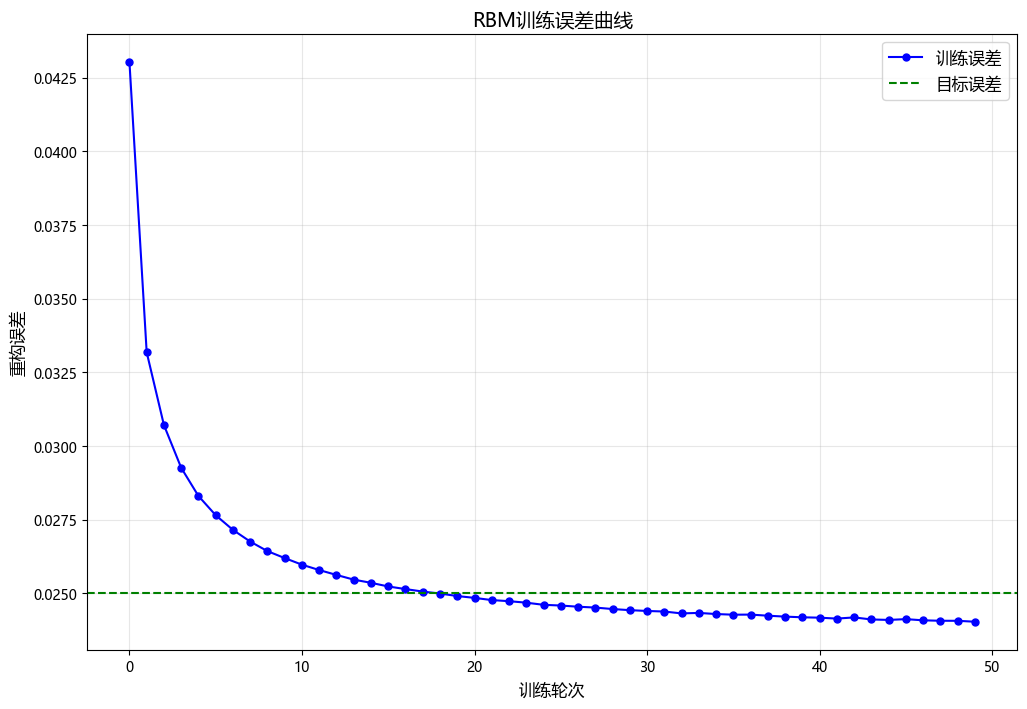

In [ ]:
def plot_training_curve(train_errors, target_error, save_path=None):
    """绘制训练曲线"""
    plt.figure(figsize=(12, 8))
    plt.plot(train_errors, 'b-', marker='o', markersize=5, label='训练误差')
    plt.axhline(y=target_error, color='g', linestyle='--', label='目标误差')
    plt.xlabel('训练轮次', fontsize=12)
    plt.ylabel('重构误差', fontsize=12)
    plt.title('RBM训练误差曲线', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_training_curve(trainer.train_errors, target_error, './images/training_curve.png')

Reconstruction MSE (using p_v): 0.005481


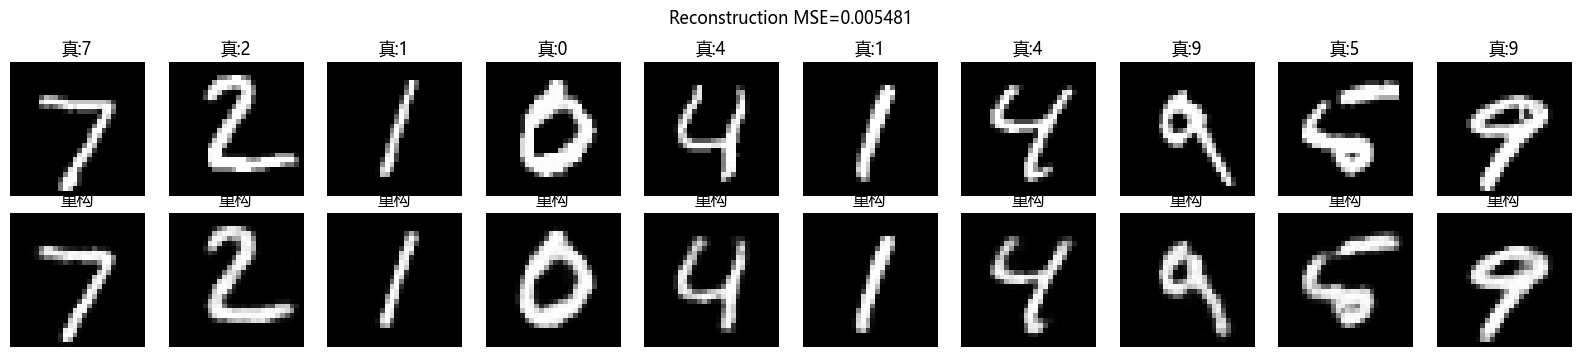

In [10]:
def show_reconstruction(rbm, loader, device, save_path):
    rbm.eval()
    device = device

    data_batch, labels_batch = next(iter(loader))
    v_in = data_batch.view(data_batch.size(0), -1).to(device)

    with torch.no_grad():
        p_h, _ = rbm.visible_to_hidden(v_in)
        p_v, _ = rbm.hidden_to_visible(p_h)

    mse = torch.mean((v_in - p_v) ** 2).item()
    print(f"Reconstruction MSE (using p_v): {mse:.6f}")

    n = 10
    fig, axes = plt.subplots(2, n, figsize=(n*1.6, 3.6))
    orig = v_in.cpu().numpy().reshape(-1, 28, 28)
    recon = p_v.cpu().numpy().reshape(-1, 28, 28)

    for i in range(n):
        axes[0, i].imshow(orig[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f"真:{int(labels_batch[i].item())}")

        axes[1, i].imshow(recon[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f"重构")

    plt.suptitle(f"Reconstruction MSE={mse:.6f}")
    plt.tight_layout()
    plt.show()

    fig.savefig(save_path, dpi=150, bbox_inches='tight')

show_reconstruction(rbm, test_loader, device, './images/reconstruction_compare.png')

classifier epoch 1, loss=1.6481
classifier epoch 2, loss=0.9253
classifier epoch 3, loss=0.6784
classifier epoch 4, loss=0.5602
classifier epoch 5, loss=0.4910
classifier epoch 6, loss=0.4454
classifier epoch 7, loss=0.4118
classifier epoch 8, loss=0.3868
classifier epoch 9, loss=0.3672
classifier epoch 10, loss=0.3508
classifier epoch 11, loss=0.3369
classifier epoch 12, loss=0.3255
classifier epoch 13, loss=0.3150
classifier epoch 14, loss=0.3064
classifier epoch 15, loss=0.2982
classifier epoch 16, loss=0.2913
classifier epoch 17, loss=0.2845
classifier epoch 18, loss=0.2789
classifier epoch 19, loss=0.2733
classifier epoch 20, loss=0.2681
Test classifier accuracy on RBM features: 90.10%


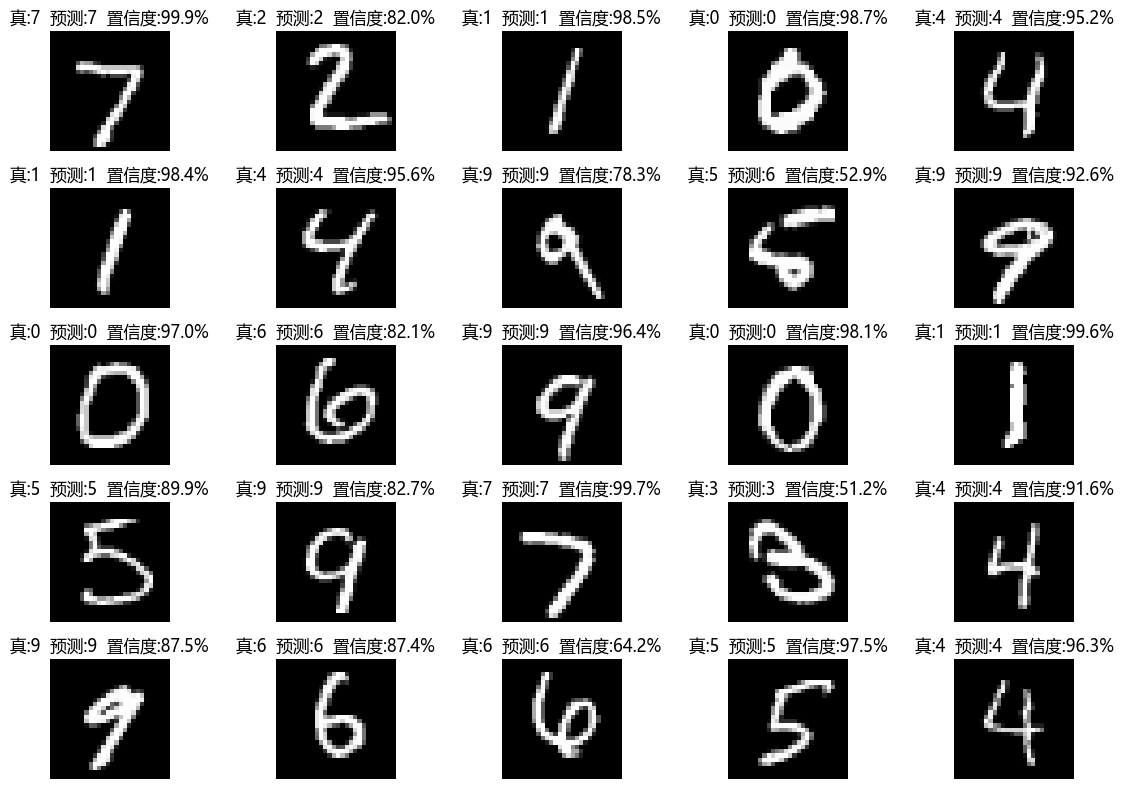

In [7]:
from torch.utils.data import TensorDataset, DataLoader

def extract_hidden_features(loader, rbm, device, max_samples=None):
    rbm.eval()
    X_list, y_list = [], []
    with torch.no_grad():
        for data, labels in loader:
            data = data.view(data.size(0), -1).to(device)
            data = torch.bernoulli(data)
            p_h, _ = rbm.visible_to_hidden(data)
            X_list.append(p_h.cpu())
            y_list.append(labels.cpu())
            if max_samples is not None and sum(x.size(0) for x in X_list) >= max_samples:
                break
    X = torch.cat(X_list)
    y = torch.cat(y_list)
    if max_samples is not None:
        X = X[:max_samples]; y = y[:max_samples]
    return X, y

X_train, y_train = extract_hidden_features(train_loader, rbm, device, max_samples=10000)
X_test,  y_test  = extract_hidden_features(test_loader,  rbm, device, max_samples=2000)

# 训练简单线性分类器
clf = nn.Linear(rbm.n_hidden, 10).to(device)
opt = torch.optim.Adam(clf.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)

for epoch in range(20):
    clf.train()
    total_loss = 0.0
    for xb, yb in train_dl:
        xb = xb.to(device); yb = yb.to(device)
        opt.zero_grad()
        logits = clf(xb)
        loss = loss_fn(logits, yb)
        loss.backward(); opt.step()
        total_loss += loss.item() * xb.size(0)
    print(f"classifier epoch {epoch+1}, loss={total_loss/len(train_dl.dataset):.4f}")

clf.eval()
with torch.no_grad():
    preds = clf(X_test.to(device)).argmax(dim=1).cpu().numpy()
    acc = (preds == y_test.numpy()).mean()
print(f"Test classifier accuracy on RBM features: {acc*100:.2f}%")

n = 25
fig, axes = plt.subplots(5, 5, figsize=(12, 8))
axes = axes.flatten()
shown = 0
it = iter(test_loader)
while shown < n:
    data, labels = next(it)
    for i in range(data.size(0)):
        if shown >= n: break
        img = data[i].squeeze().cpu().numpy()
        v = data[i].view(1, -1).to(device)
        v = torch.bernoulli(v)
        with torch.no_grad():
            p_h, _ = rbm.visible_to_hidden(v)
            logits = clf(p_h.to(device))
            probs = torch.softmax(logits, dim=1)
            pred = int(probs.argmax(dim=1).item())
            conf = float(probs[0, pred].item())
        true = int(labels[i].item())
        ax = axes[shown]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"真:{true}  预测:{pred}  置信度:{conf*100:.1f}%")
        ax.axis('off')
        shown += 1
plt.tight_layout(); 
plt.show()

In [8]:
torch.save(rbm.state_dict(), './models/rbm.pth')
torch.save(clf.state_dict(), './models/clf.pth')